In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Creación del vector de fechas
fechas = [
    "{:4d}{:02d}".format(year, month)
    for year in range(1995, 2022)
    for month in range(1, 13)
]
fechas = [fecha for fecha in fechas if fecha >= "199507" and fecha <= "202104"]
fechas[0], fechas[-1], len(fechas)

('199507', '202104', 310)

In [5]:
# Lectura de los archivos
url = (
    "https://raw.githubusercontent.com/"
    "jdvelasq/datalabs/master/datasets/precio_bolsa_nacional/csv/{}.csv"
)

org_df = pd.concat([pd.read_csv(url.format(fecha)) for fecha in fechas])
org_df.head()

,Fecha,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1995-07-21,1.073,1.0,1.0,1.0,1.0,1.0,5.0,6.0,6.0,...,5.0,1.0,1.0,5.0,12.0,16.67,11.929,5.0,1.0,1.0
1,1995-07-22,1.073,1.073,1.0,1.0,1.0,1.073,1.303,1.303,1.303,...,1.073,1.0,1.0,1.0,1.303,2.5,2.5,1.303,1.073,1.073
2,1995-07-23,1.073,1.0,1.0,1.0,1.0,1.0,0.1,1.0,1.0,...,1.0,0.1,0.1,1.0,1.238,1.238,1.238,1.238,1.073,1.0
3,1995-07-24,1.0,1.0,0.99,1.0,1.0,1.073,3.0,3.0,3.0,...,1.073,1.073,3.0,2.0,18.63,22.5,9.256,3.0,1.073,1.0
4,1995-07-25,0.99,0.99,0.989,0.99,0.99,1.073,1.263,1.263,1.263,...,1.073,1.073,1.073,1.073,1.263,1.5,1.263,1.263,1.073,0.99


In [6]:
melted_df = pd.melt(
    org_df,
    id_vars="Fecha",
    var_name="Hora",
    value_name="Precio",
)
melted_df = melted_df.sort_values(["Fecha", "Hora"]).reset_index(drop=True)
melted_df.head()

,Fecha,Hora,Precio
0,1995-07-21,0,1.073
1,1995-07-21,1,1.0
2,1995-07-21,10,6.0
3,1995-07-21,11,9.256
4,1995-07-21,12,9.256


In [7]:
melted_df.dtypes

Fecha     object
Hora      object
Precio    object
dtype: object

In [8]:
melted_df.Precio.isna().sum()

np.int64(21)

In [9]:
# Tamaño original del dataframe
melted_df.shape

(228528, 3)

In [10]:
# Eliminación de NA y tamaño final del dataframe
melted_df = melted_df.dropna()
melted_df.shape

(228507, 3)

In [11]:
# Búsqueda de registros con str en los precios
melted_df[melted_df["Precio"].map(lambda x: isinstance(x, str))].sort_values("Precio")

,Fecha,Hora,Precio
179327,2015-09-25,9,"1.004,81"
179314,2015-09-25,18,"1.004,81"
179358,2015-09-27,14,"1.014,81"
179354,2015-09-27,10,"1.014,81"
179362,2015-09-27,18,"1.014,81"
...,...,...,...
179804,2015-10-15,6,"990,52"
179805,2015-10-15,7,"990,52"
179753,2015-10-13,3,"990,52"
179754,2015-10-13,4,"990,52"


In [12]:
# Se elimina el '.' de los miles
melted_df["Precio"] = melted_df["Precio"].map(
    lambda x: x.replace(".", "") if isinstance(x, str) else x
)

In [13]:
# Se reemplaza la ',' por '.'
melted_df["Precio"] = melted_df["Precio"].map(
    lambda x: float(x.replace(",", ".")) if isinstance(x, str) else x
)

In [14]:
# Vefificación
melted_df["Precio"][melted_df["Precio"].map(lambda x: isinstance(x, str))].sort_values()

Series([], Name: Precio, dtype: float64)

In [15]:
# Revisión de los tipos de datos
melted_df.dtypes

Fecha      object
Hora       object
Precio    float64
dtype: object

In [16]:
# Cálculo de los precios diarios y renombramiento de la columna
precios_df = melted_df.groupby(["Fecha"]).agg({"Precio": "mean"})
precios_df = precios_df.rename(columns={"Precio": "Precio diario"})
precios_df.head()

,Precio diario
Fecha,
1995-07-21,4.924333
1995-07-22,1.269500
1995-07-23,0.953083
1995-07-24,4.305917
1995-07-25,1.149167


In [17]:
# Tranformación del indice a tipo fecha
precios_df.index = pd.to_datetime(precios_df.index)

In [18]:
# Cálculo del precio promedio por mes
precios_df["Precio mensual"] = precios_df.groupby(
    [precios_df.index.year, precios_df.index.month]
)["Precio diario"].transform("mean")

precios_df.head()

,Precio diario,Precio mensual
Fecha,,
1995-07-21,4.924333,1.552087
1995-07-22,1.269500,1.552087
1995-07-23,0.953083,1.552087
1995-07-24,4.305917,1.552087
1995-07-25,1.149167,1.552087


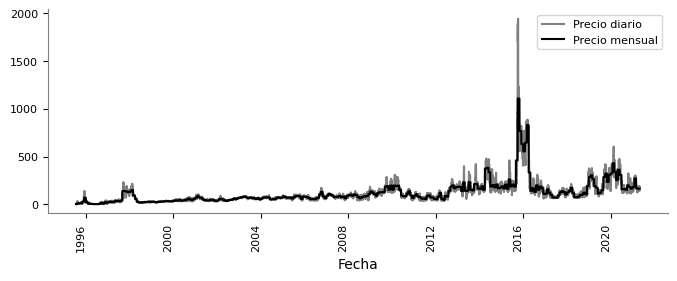

In [20]:
precios_df.plot(style=["gray", "k"], figsize=(8, 3))
plt.xticks(rotation="vertical", fontsize=8)
plt.yticks(fontsize=8)
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(fontsize=8)

if os.path.exists("../files/images") is False:
    os.makedirs("../files/images")

plt.savefig("../files/images/precios.png", bbox_inches="tight")

plt.show()